

I had no prior experience with LIDAR, so It this project took more time than expected. Here is how I approached this problem.

I browsed various LIDAR datasets from various sources including Opentopography (https://opentopography.org/), OpenData DC (https://opendata.dc.gov/) etc. I initially started with the Golden Gate(SF, Calafornia) Dataset and begian exploring it using QGIS. The data set was not classified and massive (9 million points), so I begin searching for classified dataset as well methods to segment buildings effectively.

I found an aws tutorial [repository](https://github.com/aws-samples/aws-open-data-satellite-lidar-tutorial) where they trained a VGG-16 Unet model to segment buildings and provided a copy of trained network as well but I found a classified dataset OpenTopography of Gore,NZ so I decided to go with it.

Quick rundown of what I will do
1. Load up a smaller section of the cloud, analyze it
2. Cluster the buildings
3. Calculate heights
4. Do the steps on the actual data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
cd '/content/drive/My Drive/lidar'

/content/drive/My Drive/lidar


In [ ]:
!pip install matplotlib
!pip install laspy
# !pip install geopandas
# !pip install pyntcloud
# !pip install gdal
# !pip install cuML

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for laspy: filename=laspy-2.4.1-py3-none-any.whl size=68045 sha256=762374b60718fccd63bb8b7a76a657ab202294aebeaed99d85cfb4d148df5b23
  Stored in directory: /root/.cache/pip/wheels/04/a4/0c/c8e8ba29abc06fafe864c7c4402748ceb617a7c057e8cc8579
Successfully built laspy


In [ ]:
import os
import matplotlib.pyplot as plt
import laspy
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import pyntcloud

In [ ]:
data_folder = "data"

Just testing out laspy here.

Gore_nz_smol is a smaller subset of the area used for testing.

In [ ]:
# Open the .laz file
with laspy.open('data/gore_nz_smol.las') as fh:
    print('Points from Header:', fh.header.point_count)
    las = fh.read()
    print(las)
    print('Points from data:', len(las.points))
    ground_pts = las.classification == 2
    bins, counts = np.unique(las.return_number[ground_pts], return_counts=True)
    print('Ground Point Return Number distribution:')
    for r,c in zip(bins,counts):
        print('    {}:{}'.format(r,c))

Points from Header: 89691
<LasData(1.4, point fmt: <PointFormat(6, 0 bytes of extra dims)>, 89691 points, 2 vlrs)>
Points from data: 89691
Ground Point Return Number distribution:
    1:26568
    2:4309
    3:185
    4:1


In [ ]:
point_records = las.points
pointformat = las.point_format
# for spec in pointformat:
#     print(spec.name)

# list(pointformat.dimension_names)

Online articles addresing return number mentioned vegetation having multiple return number but not much was said about buildings or ground. So I decided to stick only the first return pulse.

In [ ]:
ground_points = las.points[(las.classification == 2) & (las.return_number == 1)]
building_points = las.points[(las.classification == 6) & (las.return_number == 1)]

Drawing a density plot of the ground points to check if ground is plane enough.By observing the density plot, I could determine if taking the average height of the ground points is a suitable representation of a planar surface.

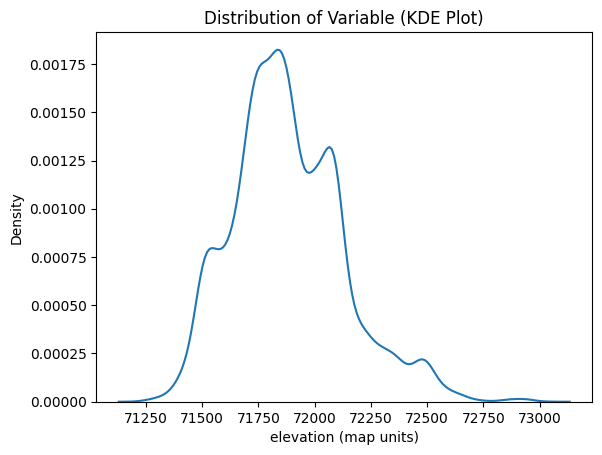

248.41469817783866
71883.00267238784


In [29]:
import seaborn as sns

def show_stats(points,xlabel = 'Variable', ylabel =  'Density'):
  sns.kdeplot(points)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title('Distribution of Variable (KDE Plot)')
  plt.show()
  print(np.std(points))
  print(np.mean(points))

show_stats(ground_points["Z"],"elevation (map units)")

The standard deviation is small enough. Avg height of ground points can be used as a plane now.

Below is the lidar cloud we are dealing with for testing.

<ipython-input-10-f9ba25ab3955>:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x[cls_indices], y[cls_indices], c=cmap(i), label=cls, s=0.1)


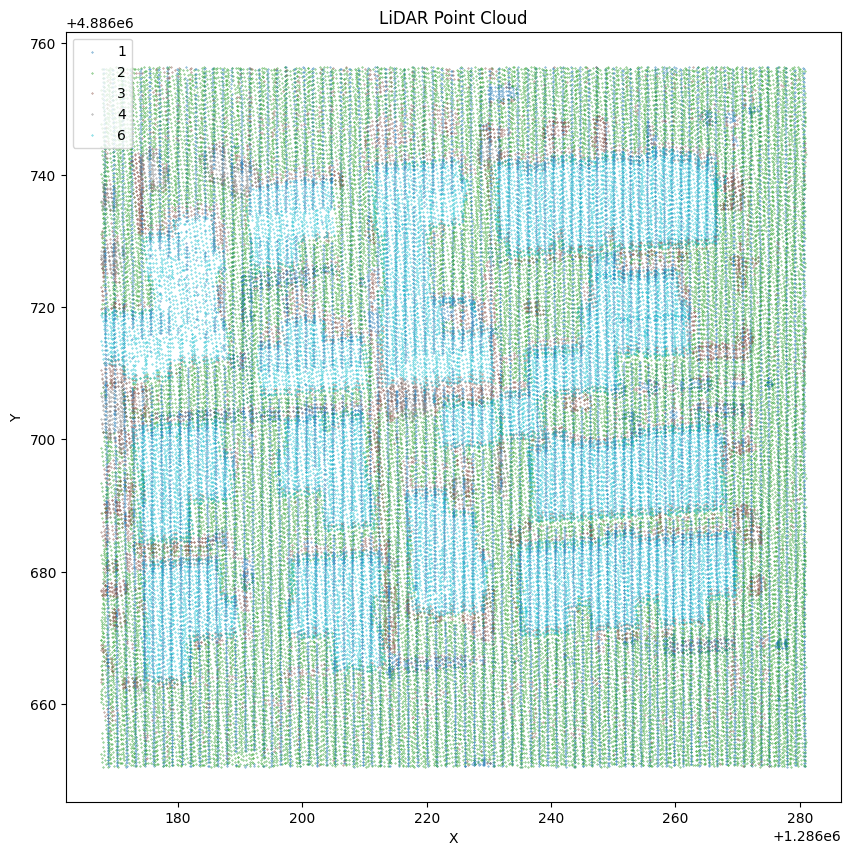

In [ ]:
x = las.x
y = las.y
classification = las.classification

# Get unique classification values
unique_classes = list(set(classification))

# Create a categorical color map for unique classes
cmap = plt.get_cmap("tab10", len(unique_classes))

# Create a scatter plot with color-coded points
plt.figure(figsize=(10, 10))
for i, cls in enumerate(unique_classes):
    cls_indices = classification == cls
    plt.scatter(x[cls_indices], y[cls_indices], c=cmap(i), label=cls, s=0.1)

plt.title('LiDAR Point Cloud')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

Below we take a look at the buildings and take a idea of their height distribution.

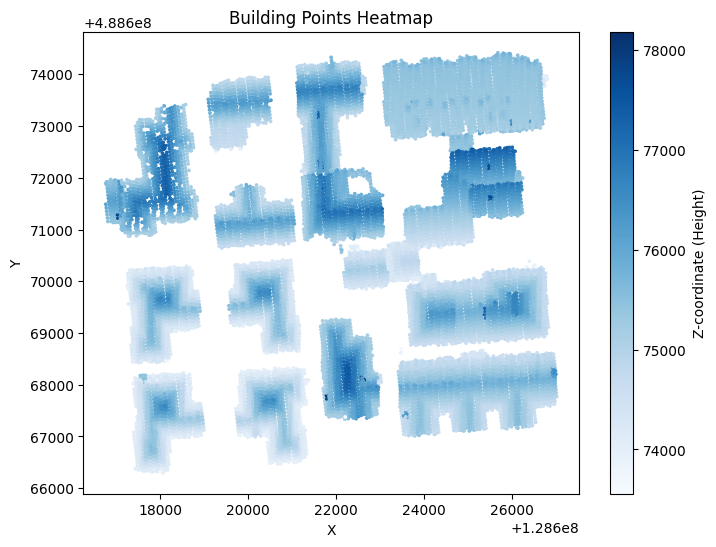

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def draw_building_heatmap(building_points):
    # Extract X, Y, Z coordinates of building points
    x = building_points["X"]
    y = building_points["Y"]
    z = building_points["Z"]

    # Set up the heatmap figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create the heatmap
    heatmap = ax.scatter(x, y, c=z, cmap='Blues', s=3)

    # Set the colorbar
    cbar = plt.colorbar(heatmap)
    cbar.set_label('Z-coordinate (Height)', rotation=90)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Building Points Heatmap')

    # Show the plot
    plt.show()

draw_building_heatmap(building_points)

We can see that towders the center of almost all the buildings, the height increases steadily. This indicates that the buildings may have sloped roofs like this one.

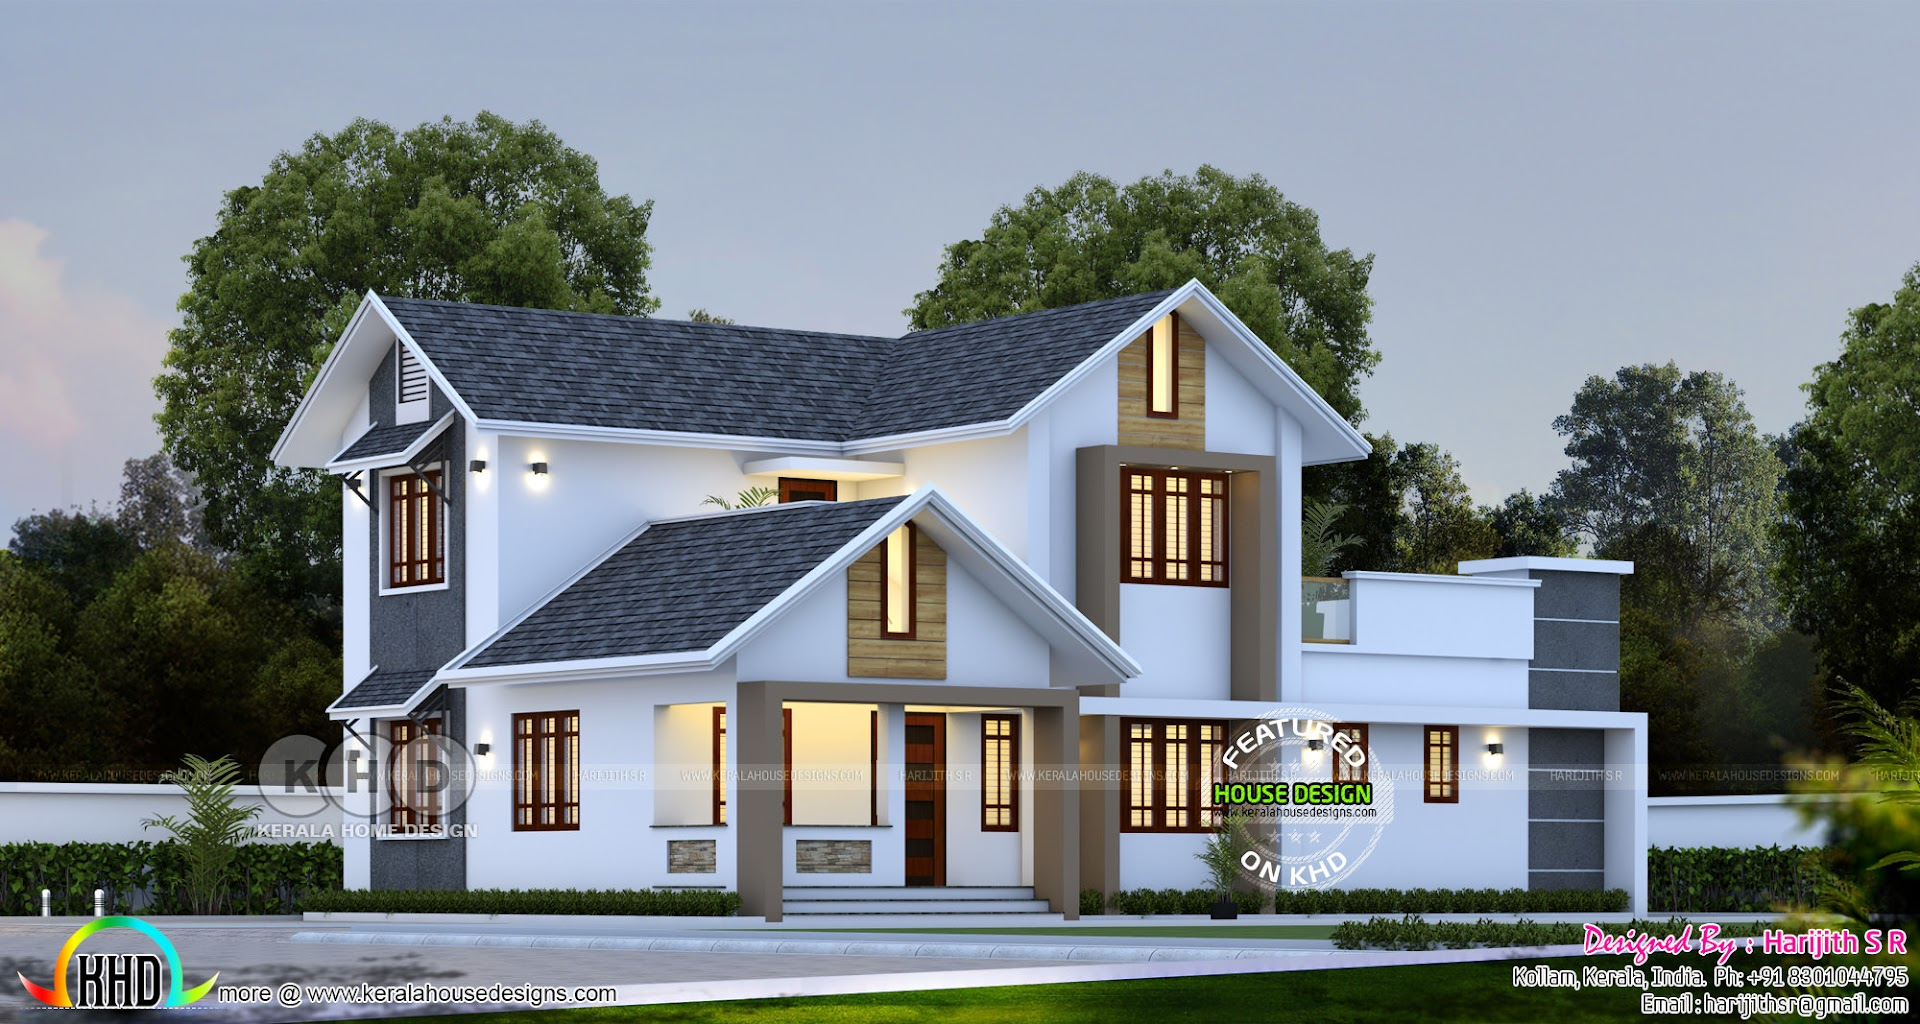

DBScan is used to cluster the buildings.

Initially I used K-Means, hoping that It would work but it didn't, even with the elbow method. After reading [this](https://soroushhashemifar.medium.com/kmeans-vs-dbscan-d9d5f9dbee8b) and [this](https://www.tutorialspoint.com/what-is-the-difference-between-k-means-and-dbscan), I concluded that It did'nt work for the following reasons.


*   K Means cannot handle noise
*   K Means needs a circular or globlular point arrangement to work effectively

The problem of obtaining the best parameters still persited, however. [Trying elbow method for obtaining Epsilon value](https://towardsdatascience.com/explaining-dbscan-clustering-18eaf5c83b31) did not work either.

I ended up using trial and error to get a suitable value.

Number of buildings: 11


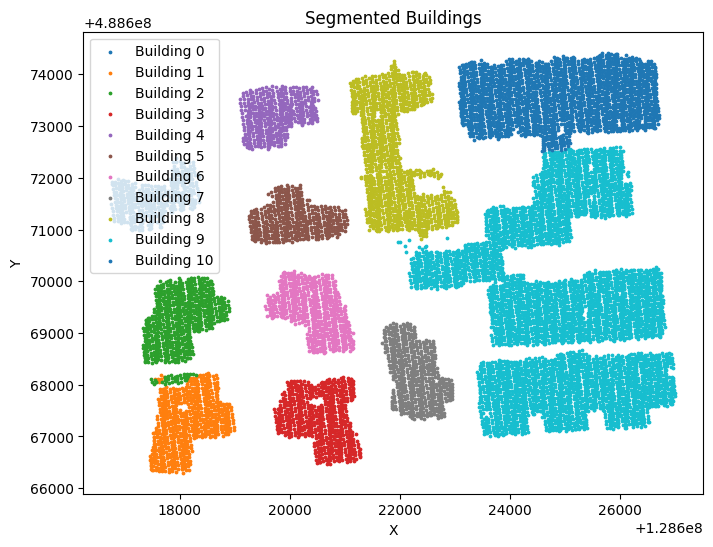

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

def segment_buildings(las):
  building_points = las.points[(las.classification == 6) & (las.return_number == 1)]
  x = building_points["X"]
  y = building_points["Y"]
  z = building_points["Z"]

  feature_matrix = np.column_stack((x, y, z))

  # Perform DBSCAN
  epsilon = 500
  min_samples = 100

  dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
  labels = dbscan.fit_predict(feature_matrix)

  unique_labels = np.unique(labels)
  unique_labels = unique_labels[unique_labels != -1]

  num_buildings = len(unique_labels)
  print("Number of buildings:", num_buildings)

  return unique_labels, labels, feature_matrix

unique_labels, labels, feature_matrix = segment_buildings(las)
# Color-coded 2D scatter plot
plt.figure(figsize=(8, 6))
for label in unique_labels:
    cluster_points = feature_matrix[labels == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label="Building " + str(label), s=3)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Segmented Buildings")
plt.legend()
plt.show()

This is not perfect by any means but a good start. We can work with this for now.

In [ ]:
avg_grnd_height = np.mean(ground_points["Z"])

Since we have houses with sloped roofs, I decided to keep track of max and min heights as well. One issue I see here is that some outliers (too low or too high points may interfere as a single point is needed to pass the max/min filter)

In [25]:
building_heights = []
building_min_heights = []
building_max_heights = []

for label in unique_labels:
    building_points = feature_matrix[labels == label]
    building_height = (np.mean(building_points[:, 2]) - avg_grnd_height)/1000  # Mean of Z coordinates
    building_min_height = (np.min(building_points[:, 2]) - avg_grnd_height)/1000  # Minimum of Z coordinates
    building_max_height = (np.max(building_points[:, 2]) - avg_grnd_height)/1000  # Maximum of Z coordinates

    building_heights.append(building_height)
    building_min_heights.append(building_min_height)
    building_max_heights.append(building_max_height)

    print("Building", label, "height:", building_height, "m")
    print("Building", label, "min height:", building_min_height, "m")
    print("Building", label, "max height:", building_max_height, "m")


Building 0 height: 4.427732690609817 m
Building 0 min height: 3.43299732761216 m
Building 0 max height: 5.49899732761216 m
Building 1 height: 3.068838534961236 m
Building 1 min height: 2.14099732761216 m
Building 1 max height: 4.50899732761216 m
Building 2 height: 3.192430576982442 m
Building 2 min height: 2.09999732761216 m
Building 2 max height: 4.75799732761216 m
Building 3 height: 3.04727253197183 m
Building 3 min height: 2.04599732761216 m
Building 3 max height: 4.49099732761216 m
Building 4 height: 3.5110826934658252 m
Building 4 min height: 2.27099732761216 m
Building 4 max height: 4.48299732761216 m
Building 5 height: 3.6639915472653373 m
Building 5 min height: 2.85199732761216 m
Building 5 max height: 4.39799732761216 m
Building 6 height: 3.2898916614559566 m
Building 6 min height: 2.22899732761216 m
Building 6 max height: 4.68599732761216 m
Building 7 height: 4.326984748995804 m
Building 7 min height: 3.38999732761216 m
Building 7 max height: 5.63099732761216 m
Building 8 hei

I could not find a reliable way to know to convert map units (z distance here) to a everyday unit like metre using laspy. However using lasinfo, I deduced that I can replace 1000 map units with one metre.

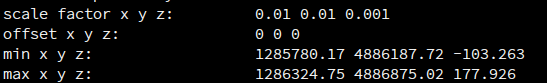

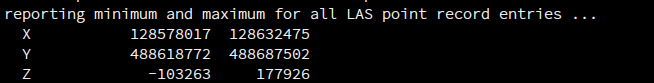

Now we try all this on the actual point cloud

In [ ]:
with laspy.open('data/gore_nz.las') as fh:
    print('Points from Header:', fh.header.point_count)
    las_gore = fh.read()

Points from Header: 2519604


In [ ]:
ground_points_gore = las_gore.points[(las_gore.classification == 2) & (las_gore.return_number == 1)]
building_points_gore = las_gore.points[(las_gore.classification == 6) & (las_gore.return_number == 1)]
unclassified_points_gore = las_gore.points[(las_gore.classification == 1) & (las_gore.return_number == 1)]

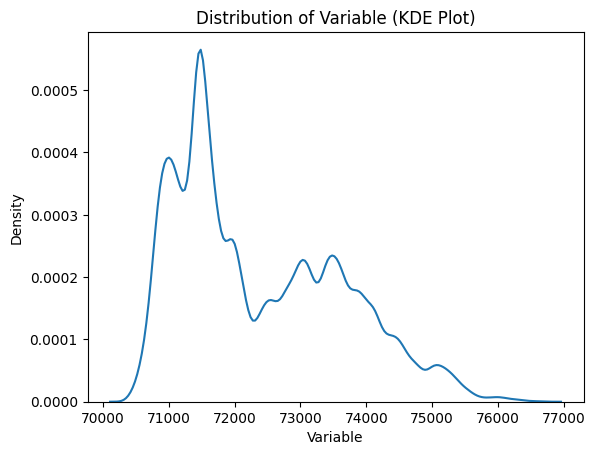

1255.150521028262
72386.75129961317


In [ ]:
show_stats(ground_points_gore["Z"])

Still within reasonable limits

Number of buildings: 541


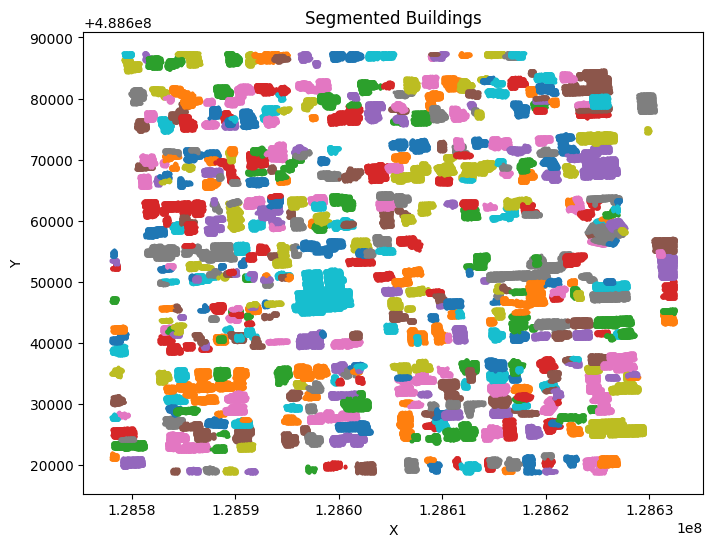

541 buildings


In [38]:
unique_labels_gore, labels_gore, feature_matrix_gore = segment_buildings(las_gore)
# Color-coded 2D scatter plot
plt.figure(figsize=(8, 6))
for label in unique_labels_gore:
    cluster_points_gore = feature_matrix_gore[labels_gore == label]
    plt.scatter(cluster_points_gore[:, 0], cluster_points_gore[:, 1], label="Building " + str(label), s=3)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Segmented Buildings")
# plt.legend()
plt.show()
print(len(unique_labels_gore), "buildings")

In [ ]:
avg_grnd_height_gore = np.mean(ground_points_gore["Z"])

In [30]:
building_heights_gore = []
building_min_heights_gore = []
building_max_heights_gore = []

for label in unique_labels_gore:
    building_points = feature_matrix_gore[labels_gore == label]
    building_height_gore = (np.mean(building_points[:, 2]) - avg_grnd_height_gore)/1000  # Mean of Z coordinates
    building_min_height_gore = (np.min(building_points[:, 2]) - avg_grnd_height_gore)/1000  # Minimum of Z coordinates
    building_max_height_gore = (np.max(building_points[:, 2]) - avg_grnd_height_gore)/1000  # Maximum of Z coordinates

    building_heights_gore.append(building_height_gore)
    building_min_heights_gore.append(building_min_height_gore)
    building_max_heights_gore.append(building_max_height_gore)

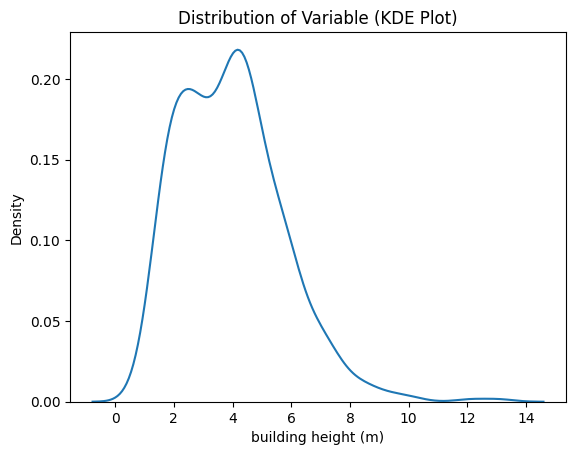

1.7847031925106132
3.947284463001535


In [39]:
show_stats(building_heights_gore,"building height (m)")

Buildings with heights less than 3 m are strange. They might be small sheds or greenhouses.

In [36]:
print(len([height for height in building_heights_gore if height < 3]))

187


Thats a lot

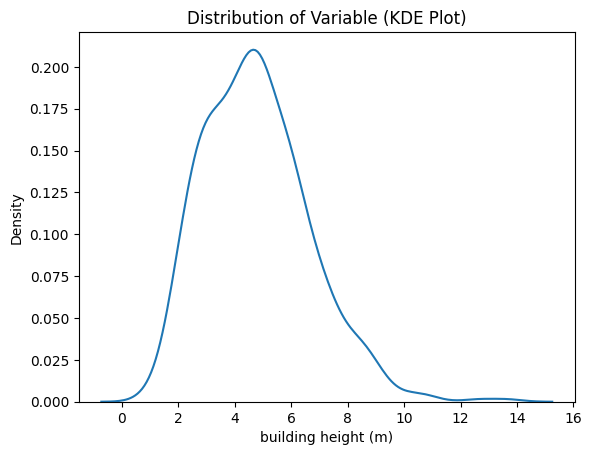

1.8769495568133387
4.774110068224168
101


In [42]:
show_stats(building_max_heights_gore,"building height (m)")
print(len([height for height in building_max_heights_gore if height < 3]))

While 101 is still a lot, To address this, I think removing outliers with smaller distance from ground might not be a good solution (again, due to sloped roofs). Some better method to counter false points is required.